# Instrumental Variable Estimation: Basic Examples

https://bashtage.github.io/linearmodels/doc/iv/examples/basic-examples.html

In [1]:
from linearmodels.iv import IV2SLS, IVGMM, IVGMMCUE, IVLIML

## Wages of Married Women

In [2]:
import numpy as np
from statsmodels.api import add_constant
from linearmodels.datasets import mroz
import lmdiag

In [3]:
data = mroz.load()
data = data.dropna()
data = add_constant(data, has_constant='add')

/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


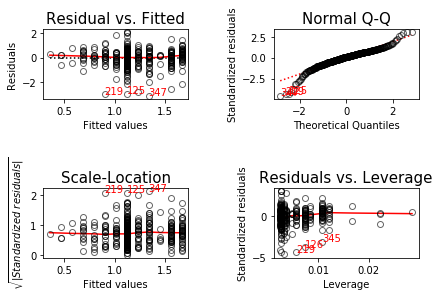

In [4]:
from linearmodels.iv import IV2SLS
res_ols = IV2SLS(np.log(data.wage), data[['const','educ']], None, None).fit(cov_type='unadjusted')
# print(res_ols)
lmdiag.plot(res_ols);

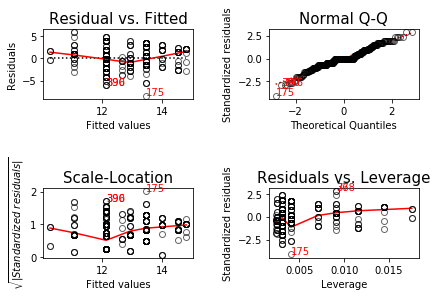

In [5]:
res_first = IV2SLS(data.educ, data[['const','fatheduc']], None, None).fit(cov_type='unadjusted')
# print(res_first)
data['educ_hat'] = data.educ - res_first.resids
lmdiag.plot(res_first);

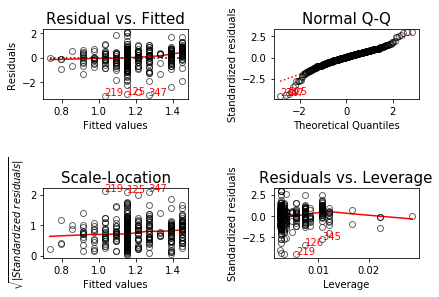

In [6]:
res_second = IV2SLS(np.log(data.wage), data[['const']], data.educ, data.fatheduc).fit(cov_type='unadjusted')
# print(res_second)
lmdiag.plot(res_second);

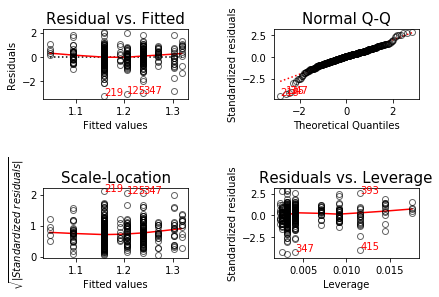

In [7]:
res_direct = IV2SLS(np.log(data.wage), data[['const','educ_hat']], None, None).fit(cov_type='unadjusted')
# print(res_direct)
lmdiag.plot(res_direct);

## Wages of Men

In [8]:
from linearmodels.datasets import wage
men = wage.load()
# print(wage.DESCR)
men = men[['educ','wage','sibs','exper']]
men = add_constant(men)
men = men.dropna()

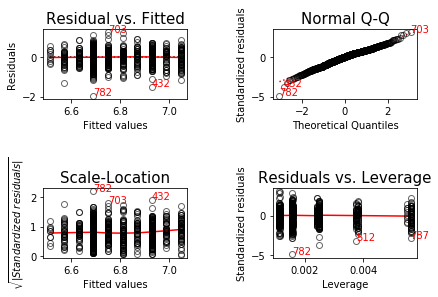

In [9]:
res_ols = IV2SLS(np.log(men.wage), men[['const', 'educ']], None, None).fit(cov_type='unadjusted')
# print(res_ols)
lmdiag.plot(res_ols);

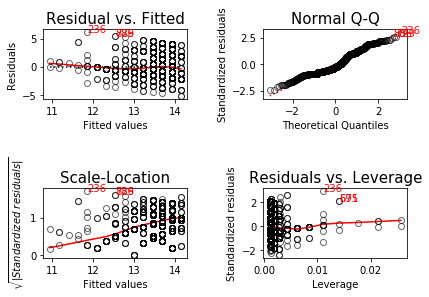

In [10]:
res_first = IV2SLS(men.educ, men[['const', 'sibs']], None, None).fit(cov_type='unadjusted')
# print(res_first.summary)
lmdiag.plot(res_first);

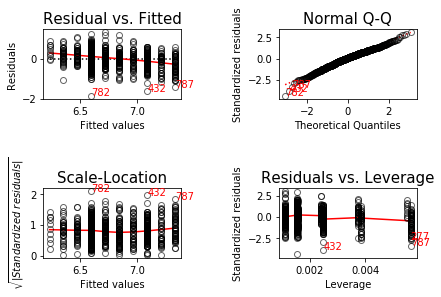

In [11]:
res = IV2SLS(np.log(men.wage), men.const, men.educ, men.sibs).fit(cov_type='unadjusted')
# print(res.summary)
lmdiag.plot(res);

## Weighted IV

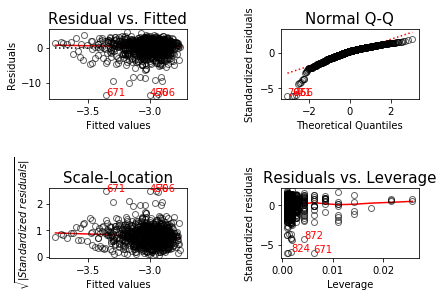

In [12]:
res2 = res.resids ** 2
fgls_mod = IV2SLS(np.log(res2), men[['const','sibs','exper']], None, None)
fgls_res = fgls_mod.fit()
sigma2_hat = np.exp(np.log(res2) - fgls_res.resids)
# print(fgls_res)
lmdiag.plot(fgls_res);

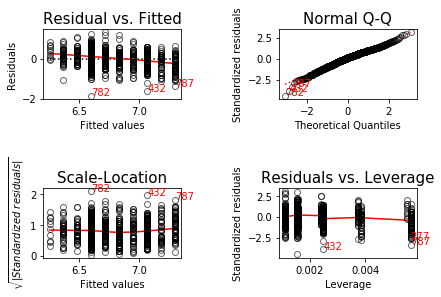

In [13]:
res_gls = IV2SLS(np.log(men.wage), men.const, men.educ, men.sibs, weights=1 / sigma2_hat).fit(cov_type='unadjusted')
# print(res_gls)
lmdiag.plot(res_gls);

## Smoking and birth weight

In [14]:
from linearmodels.datasets import birthweight
data = birthweight.load()
# print(birthweight.DESCR)
data = add_constant(data)

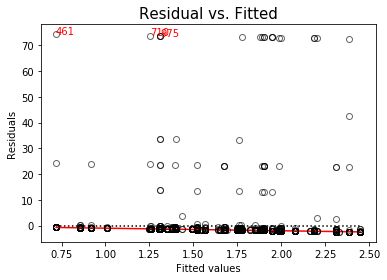

In [15]:
res = IV2SLS(data.packs, data[['const','cigprice']], None, None).fit(cov_type='unadjusted')
# print(res)
lmdiag.resid_fit(res);

/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)
/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


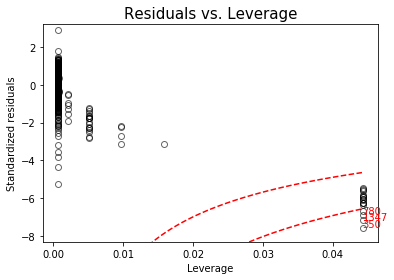

In [16]:
res = IV2SLS(np.log(data.bwght), data.const, data.packs, data.cigprice).fit(cov_type='unadjusted')
# print(res)
lmdiag.resid_lev(res);

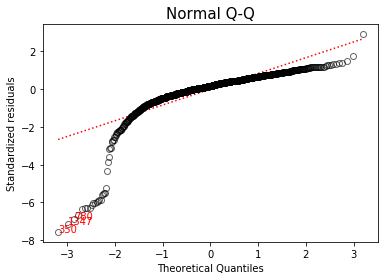

In [17]:
lmdiag.q_q(res);

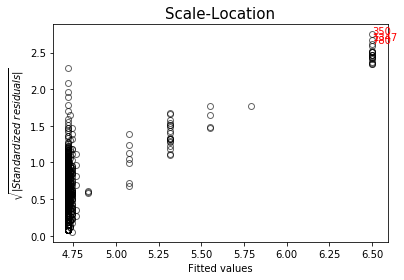

In [18]:
lmdiag.scale_loc(res);

## Proximity and education

In [19]:
from linearmodels.datasets import card
data = card.load()
# print(card.DESCR)
data = add_constant(data)

In [20]:
dep = ['wage']
endog = ['educ']
exog = ['const','exper','expersq','black','smsa','south','smsa66','reg662',
       'reg663','reg664','reg665','reg666','reg667','reg668','reg669']
instr = ['nearc4']
data = data[dep +exog+endog+ instr].dropna()

/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/lmdiag/plot.py:97: RuntimeWarning: invalid value encountered in true_divide
  h_ii = (X - mean_X) ** 2 / diff_mean_sqr + (1 / self.lm.nobs)


LinAlgError: SVD did not converge in Linear Least Squares

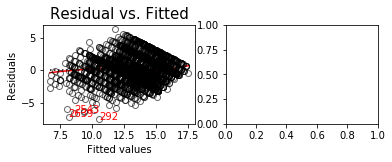

In [21]:
res = IV2SLS(data.educ, data[instr+exog], None, None).fit()
# print(res)
lmdiag.plot(res)

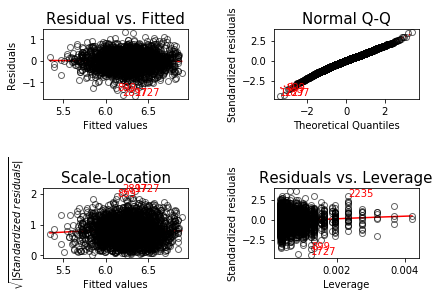

In [22]:
res = IV2SLS(np.log(data.wage), data[exog+endog],None,None).fit()
# print(res)
lmdiag.plot(res);

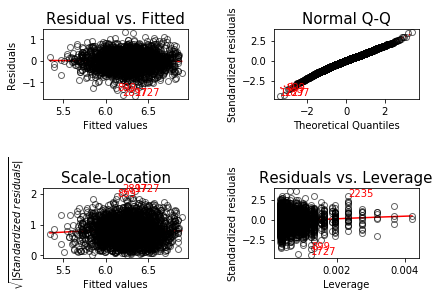

In [23]:
res = IV2SLS(np.log(data.wage), data[exog+endog],None,None).fit()
# print(res)
lmdiag.plot(res);

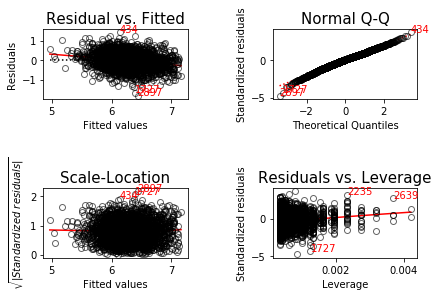

In [24]:
import numpy as np
formula = ('np.log(wage) ~ 1 + exper + expersq + black + smsa + south + smsa66 + reg662 + reg663 + reg664 + '
           'reg665 + reg666 + reg667 + reg668 + reg669 + [educ ~ nearc4]')
mod = IV2SLS.from_formula(formula, data)
res_formula = mod.fit(cov_type='unadjusted')
# print(res_formula.rsquared - res_2sls.rsquared)
lmdiag.plot(res_formula);

## Categorical Variable

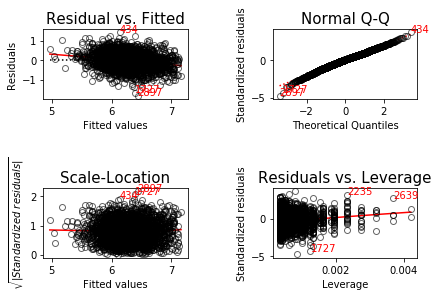

In [25]:
data['reg'] = '661'  # The default region, which was omitted
for i in range(2, 10):
    region = 'reg66' + str(i)
    data.loc[data[region] == 1, 'reg'] = region[3:]
data['reg'] = data['reg'].astype('category')
data.describe()
res_cat = IV2SLS(np.log(data.wage), data[['const','exper','expersq','black','smsa','south','smsa66','reg']], data.educ, data.nearc4).fit()
# print(res_cat)
lmdiag.plot(res_cat);

## Post-estimation diagnostics

In [26]:
data = mroz.load()
data = data.dropna()
data = add_constant(data, has_constant='add')
data['lnwage'] = np.log(data.wage)
dep = 'lnwage'
exog = ['const','exper','expersq']
endog = ['educ']
instr = ['fatheduc','motheduc']

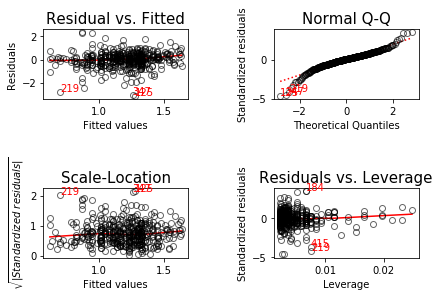

In [27]:
res = IV2SLS(data[dep],data[exog],data[endog],data[instr]).fit(cov_type='unadjusted')
# print(res)
lmdiag.plot(res);

LinAlgError: SVD did not converge in Linear Least Squares

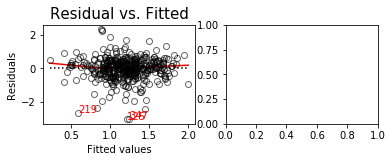

In [28]:
v = IV2SLS(data[endog],data[exog+instr],None,None).fit().resids
import pandas as pd
res_direct = IV2SLS(data[dep],pd.concat([v, data[exog]], 1),data[endog],data[instr]).fit(cov_type='unadjusted')
# print(res_direct)
lmdiag.plot(res_direct)

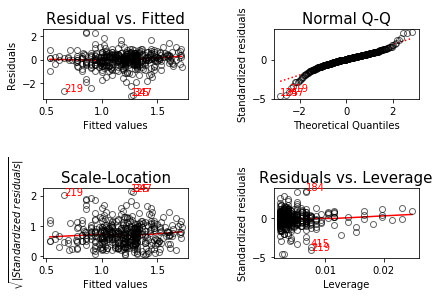

In [29]:
instr = ['fatheduc','motheduc','huseduc']
res = IV2SLS(data[dep], data[exog], data[endog], data[instr]).fit(cov_type='unadjusted')
# print(res)
lmdiag.plot(res);

## Panel IV

In [30]:
from linearmodels.datasets import jobtraining
data = jobtraining.load()
# print(jobtraining.DESCR)
data.head()
data = data.where(data.year.isin((1987,1988)))
data = data.dropna(how='all',axis=0).sort_values(['fcode','year'])
# print(data.describe())
data = data.set_index('fcode')
data = data[['year','hrsemp','grant','scrap','lscrap']]

In [31]:
deltas = data.loc[data.year == 1988] - data.loc[data.year == 1987]
deltas = add_constant(deltas, has_constant='add')
deltas = deltas.dropna()
# print(deltas.describe())

KeyError: 25.0

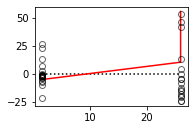

In [32]:
mod = IV2SLS(deltas.hrsemp, deltas[['const','grant']], None, None)
res = mod.fit(cov_type='unadjusted')
# print(res)
lmdiag.plot(res)

KeyError: 43.0

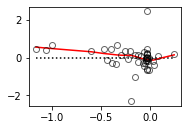

In [33]:
mod = IV2SLS.from_formula('lscrap ~ 1 + [hrsemp ~ grant]', deltas)
res_iv = mod.fit(cov_type='unadjusted')
# print(res_iv)
lmdiag.plot(res_iv)

KeyError: 19.0

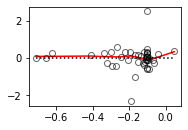

In [34]:
res_ols = IV2SLS.from_formula('lscrap ~ 1 + hrsemp', deltas).fit(cov_type='unadjusted')
# print(res_ols)
lmdiag.plot(res_ols)

# Instrumental Variable Estimation: Further Examples

https://bashtage.github.io/linearmodels/doc/iv/examples/advanced-examples.html

In [35]:
from linearmodels.iv import IVGMM, IVGMMCUE, IVLIML

In [36]:
from linearmodels.datasets import meps
data = meps.load()
data = data.dropna()
# print(meps.DESCR)

In [37]:
controls = ['totchr', 'female', 'age', 'linc','blhisp']

In [38]:
instruments = ['ssiratio', 'lowincome', 'multlc', 'firmsz']

In [39]:
from statsmodels.api import OLS, add_constant
data['const'] = 1
controls = ['const'] + controls

## 2SLS as OLS

LinAlgError: SVD did not converge in Linear Least Squares

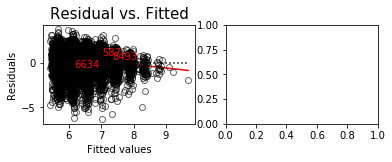

In [40]:
ivolsmod = IV2SLS(data.ldrugexp, data[['hi_empunion'] + controls], None, None)
res_ols = ivolsmod.fit()
# print(res_ols)
lmdiag.plot(res_ols)

## Just identified 2SLS

LinAlgError: SVD did not converge in Linear Least Squares

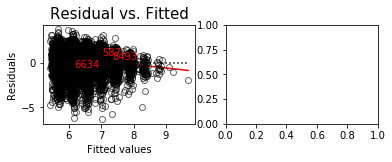

In [41]:
ivolsmod = IV2SLS(data.ldrugexp, data[['hi_empunion'] + controls], None, None)
res_ols = ivolsmod.fit()
# print(res_ols)
lmdiag.plot(res_ols)

## Multiple Instruments

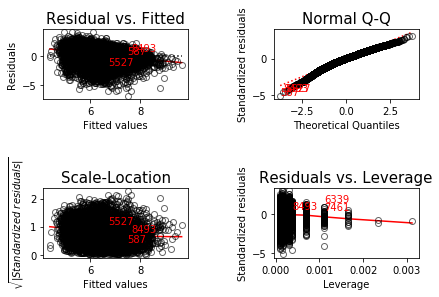

In [42]:
ivmod = IV2SLS(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
res_2sls_robust = ivmod.fit()
# print(res_2sls_robust)
lmdiag.plot(res_2sls_robust);

## Alternative covariance estimators

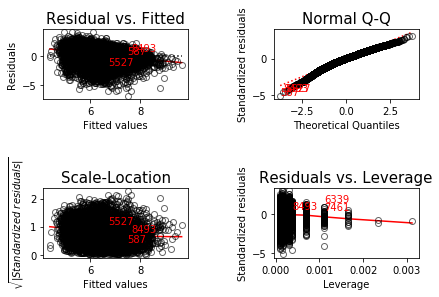

In [43]:
ivmod = IV2SLS(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
res_2sls_std = ivmod.fit(cov_type='unadjusted')
lmdiag.plot(res_2sls_std);

## GMM Estimation

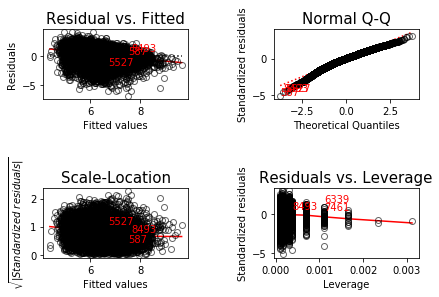

In [44]:
from linearmodels.iv import IVGMM
ivmod =IVGMM(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
res_gmm = ivmod.fit()
# print(res_gmm)
lmdiag.plot(res_gmm);

## Changing the weighting matrix structure in GMM estimation

<module 'matplotlib.pyplot' from '/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/matplotlib/pyplot.py'>

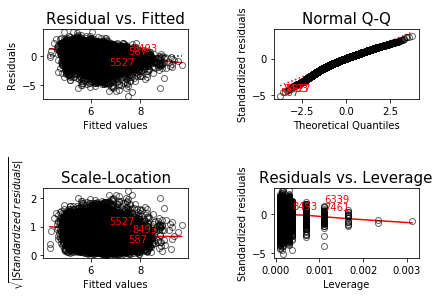

In [45]:
from linearmodels.iv import IVGMM
ivmod = IVGMM(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']],
                weight_type='clustered', clusters=data.age)
res_gmm_clustered = ivmod.fit(cov_type='clustered', clusters=data.age)
# print(res_gmm_clustered)
lmdiag.plot(res_gmm_clustered)

## Continuously updating GMM

         Current function value: 1.045365
         Iterations: 10
         Function evaluations: 660
         Gradient evaluations: 72


<module 'matplotlib.pyplot' from '/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/matplotlib/pyplot.py'>

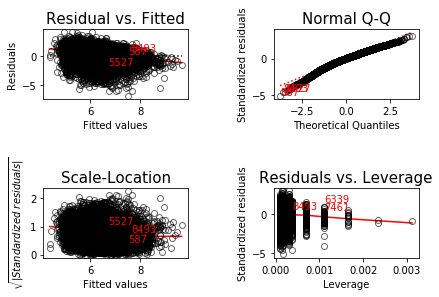

In [46]:
from linearmodels.iv import IVGMMCUE
ivmod = IVGMMCUE(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
res_gmm_cue = ivmod.fit(cov_type='robust', display=True)
# print(res_gmm_cue)
lmdiag.plot(res_gmm_cue)

## Testing endogeneity

/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/lmdiag/plot.py:97: RuntimeWarning: invalid value encountered in true_divide
  h_ii = (X - mean_X) ** 2 / diff_mean_sqr + (1 / self.lm.nobs)


LinAlgError: SVD did not converge in Linear Least Squares

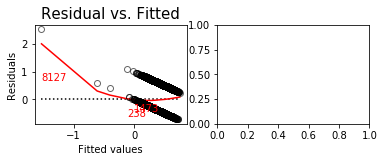

In [47]:
import pandas as pd
step1 = IV2SLS(data.hi_empunion, data[['ssiratio'] + controls], None, None).fit()
lmdiag.plot(step1)

LinAlgError: SVD did not converge in Linear Least Squares

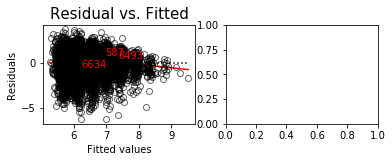

In [48]:
resids = step1.resids
exog = pd.concat([data[['hi_empunion'] + controls], resids],1)
step2 = IV2SLS(data.ldrugexp, exog, None, None).fit(cov_type='unadjusted')
# print(step2.tstats.residual **2)
lmdiag.plot(step2)

## Exogeneity Testing

<module 'matplotlib.pyplot' from '/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/matplotlib/pyplot.py'>

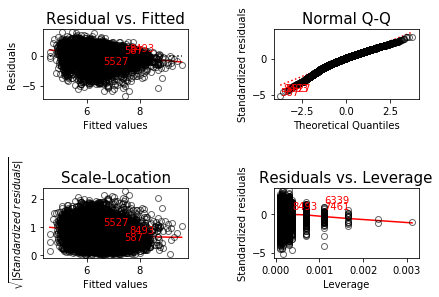

In [49]:
ivmod = IVGMM(data.ldrugexp, data[controls], data.hi_empunion, data[instruments])
res_gmm_all = ivmod.fit()
# res_gmm_all.j_stat
# print(res_gmm_all)
lmdiag.plot(res_gmm_all)

## LIML

<module 'matplotlib.pyplot' from '/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/matplotlib/pyplot.py'>

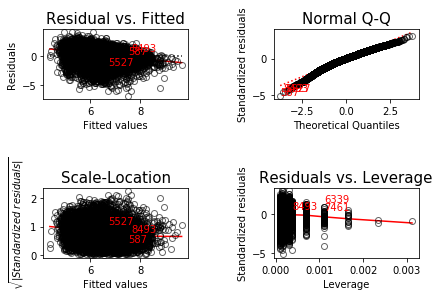

In [50]:
from linearmodels.iv import IVLIML
ivmod = IVLIML(data.ldrugexp, data[controls], data.hi_empunion, data[['ssiratio','multlc']])
res_liml = ivmod.fit(cov_type='robust')
# print(res_liml)
lmdiag.plot(res_liml)

## IV2SLS as OLS

LinAlgError: SVD did not converge in Linear Least Squares

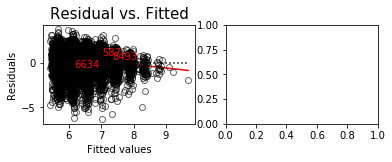

In [51]:
import pandas as pd
ivolsmod = IV2SLS(data.ldrugexp, data[['hi_empunion'] + controls], None, None)
res_ivols = ivolsmod.fit()
# print(res_ivols)
lmdiag.plot(res_ivols)

# Panel Data: Examples

https://bashtage.github.io/linearmodels/doc/panel/examples/examples.html

## Basic regression on panel data

In [52]:
from linearmodels.datasets import wage_panel
import pandas as pd
data = wage_panel.load()
year = pd.Categorical(data.year)
data = data.set_index(['nr', 'year'])
data['year'] = year
# print(wage_panel.DESCR)
# print(data.head())

/Users/Tetsu/anaconda3/envs/py4etrics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

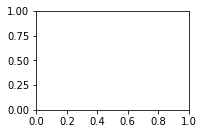

In [53]:
from linearmodels.panel import PooledOLS
import statsmodels.api as sm
exog_vars = ['black','hisp','exper','expersq','married', 'educ', 'union', 'year']
exog = sm.add_constant(data[exog_vars])
mod = PooledOLS(data.lwage, exog)
pooled_res = mod.fit()
# print(pooled_res)
lmdiag.plot(pooled_res)

## Random effects

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

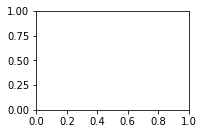

In [54]:
from linearmodels.panel import RandomEffects
mod = RandomEffects(data.lwage, exog)
re_res = mod.fit()
# print(re_res)
lmdiag.plot(re_res)

## The between estimator

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

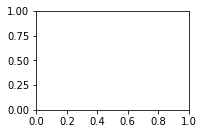

In [55]:
from linearmodels.panel import BetweenOLS
exog_vars = ['black','hisp','exper','married', 'educ', 'union']
exog = sm.add_constant(data[exog_vars])
mod = BetweenOLS(data.lwage, exog)
be_res = mod.fit()
# print(be_res)
lmdiag.plot(be_res)

## Time-invariant Variables

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

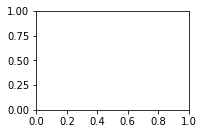

In [56]:
from linearmodels.panel import PanelOLS
exog_vars = ['expersq', 'union', 'married', 'year']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lwage, exog, entity_effects=True)
fe_res = mod.fit()
# print(fe_res)
lmdiag.plot(fe_res)

## Effects vs Dummies

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

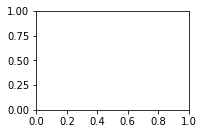

In [57]:
from linearmodels.panel import PanelOLS
exog_vars = ['expersq','union','married']
exog = sm.add_constant(data[exog_vars])
mod = PanelOLS(data.lwage, exog, entity_effects=True, time_effects=True)
fe_te_res = mod.fit()
# print(fe_te_res)
lmdiag.plot(fe_te_res)

## Using first differences

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

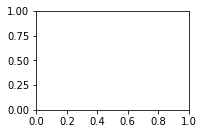

In [58]:
from linearmodels.panel import FirstDifferenceOLS
exog_vars = ['exper','expersq', 'union', 'married']
exog = data[exog_vars]
mod = FirstDifferenceOLS(data.lwage, exog)
fd_res = mod.fit()
# print(fd_res)
lmdiag.plot(fd_res)

## Heteroskedasticity Robust Covariance

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

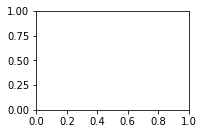

In [59]:
exog_vars = ['black','hisp','exper','expersq','married', 'educ', 'union']
exog = sm.add_constant(data[exog_vars])
mod = PooledOLS(data.lwage, exog)
robust = mod.fit(cov_type='robust')
lmdiag.plot(robust)

## Clustered by Entity

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

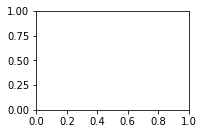

In [60]:
clust_entity = mod.fit(cov_type='clustered', cluster_entity=True)
lmdiag.plot(clust_entity)

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

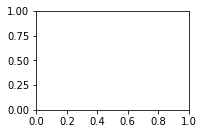

In [61]:
clust_entity_time = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True)
lmdiag.plot(clust_entity_time)

## Other clusters

TypeError: Input is no statsmodel OLS model and no linearmodels OLS model!

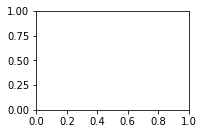

In [62]:
clust_entity = mod.fit(cov_type='clustered', clusters=data.occupation)
# print(data.occupation.value_counts())
# print(clust_entity)
lmdiag.plot(clust_entity)